<a href="https://colab.research.google.com/github/XtremeAnalytics/analytics-engineer-test-TEMPLATE/blob/main/Analytics_Engineer_Technical_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analytics Engineer Test

In this assessment, we place immense value on well-documented code. Consider comments as your trusty allies in articulating your thought process and ensuring complete transparency. This is your moment to shine, and we're eager to see your exceptional talent in action.

## PART 1: Analyzing Bitcoin Price Data
Goals:

1.  Update the daily bitcoin price data in *bitcoin_price_data.db*, a SQLite Database
2. Plot the monthly average bitcoinUSD price
3. Forecast the bitcoinUSD price for the next month (using only the historic price), and discuss the reliability of the forecast.

Resources:

*  *bitcoin_price_data.db*: SQLite database file containing historic bitcoin prices from 2022-11-14 to 2023-11-13
* *bitcoin_price_data.sql*: SQL code to generate a table of historic bitcoin prices from 2022-11-14 to 2023-11-13
*  **API**: https://api.coincap.io/v2/assets/bitcoin/history?interval=d1




### Import libraries

In [1]:
from datetime import datetime, timedelta
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import DataFrame
from sqlalchemy import create_engine
import sqlite3
import requests as re
import logging
import traceback
import plotly.express as px
from xgboost import XGBRegressor
import plotly.graph_objects as go
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 5
import utils
from sklearn.model_selection import cross_val_score, KFold
import xgboost as xgb

In [2]:
color_pal = sns.color_palette()

### Part 1, Question A: Build data pipeline to update bitcoin price

In [4]:
# Import libraries
from datetime import datetime, timedelta
import datetime as dt
import pandas as pd
from pandas import DataFrame
from sqlalchemy import create_engine
import sqlite3
import requests as re
import logging
import traceback

# 1. Logging Configuration
log_file_path = 'log.txt'
logging.basicConfig(filename=log_file_path, level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')

def main():
    
    def extract_bitcoin_price(api_url:str) -> DataFrame:
        '''
        Task to connect and extract daily bitcoin price API and convert into dataframe.
        - Argument: API URL
        - Utilize request library to extract json data from Bitcoin API 
        - Extracts the data in dictionary format and convert to dataframe
        - Perform necessary transformation to convert dataframe to suitable format
        - Returns the results as a Pandas DataFrame.
        '''
        try:
            response = re.get(api_url)
            result_dict = dict(response.json())['data']
            df = pd.DataFrame(result_dict)
            df['date'] = df['date'].apply(lambda x: x.split('T')[0])
            df['date'] = pd.to_datetime(df['date'])
            df['priceUsd'] = df['priceUsd'].astype(float).round(2)
            return df 
        
        except Exception as e:
            error_message = f"Exception occurred: {str(e)}\n{traceback.format_exc()}"
            logging.error(error_message)
            raise RuntimeError(error_message)
            
    def insert_into_sqlite(db_file: str, dataframe: DataFrame) -> str:
        '''
        Task to connect to SQLite and write bitcoin price.
        - Argument: database file name and dataframe from api website
        - Connects to SQLite using database file name
        - Obtain max id and converts to integer.
        - Obtain max date from date and filter incoming new dataframe
        - Reset index of the dataframe
        - Create a new column named 'id' in the dataframe argument with values as df.index+max_id+1
        - Writes updated dataframe into SQLite database
        - Handles exceptions by logging errors and raising a RuntimeError with detailed error information.
        '''
        try:
            # Connect to the SQLite database
            current_date = datetime.now().strftime('%Y-%m-%d')
            logging.info(f"Connecting to SQLite database")
            sqlite_conn = sqlite3.connect(f'{db_file}.db')
            cursor = sqlite_conn.cursor()
            cursor.execute('select id from bitcoin_price_data order by id desc limit 1')
            max_id = cursor.fetchone()[0]
            cursor.execute('select date from bitcoin_price_data order by id desc limit 1')
            max_date = cursor.fetchone()[0]

            # Check if there is a max_id
            if max_id:
                integer_max_id = int(max_id)
                logging.info(f'max record before {current_date} insert: {integer_max_id}')
            else:
                print("No records found.")
                integer_max_id =  0
                
            # Filter dataframe where max_date from database is not in present
            dataframe = dataframe.query(f"date > '{max_date}'")
            if not dataframe.empty:
                dataframe['date'] = dataframe['date'].dt.date
                dataframe = dataframe.reset_index()
                dataframe['id'] = dataframe.index + max_id + 1
                final_df = dataframe[['id','date','priceUsd']]

                # # Write bitcoin price data to SQLite database
                logging.info("Writing metrics to SQLite database.")
                final_df.to_sql('bitcoin_price_data', con=sqlite_conn, if_exists='append', index=False)
                logging.info("successfully loaded data into SQLite database")
                
            else:
                logging.info("No new data and nothing loaded into SQLite database")
                
            # Close the database connection
            sqlite_conn.close()
            logging.info("SQLite connection closed. Task successfully completed.")
            return "succesful update of bitcoin price"

        except Exception as e:
            error_message = f"Exception occurred: {str(e)}\n{traceback.format_exc()}"
            logging.error(error_message)
            raise RuntimeError(error_message)
            
    api_url = 'https://api.coincap.io/v2/assets/bitcoin/history?interval=d1'
    df = extract_bitcoin_price(api_url)
    insert_into_sqlite('test_db', df)

main()

### Part 1, Question B: Plot the monthly average bitcoin USD price

#### i. extract monthly average bitcoin price with SQL query

In [5]:
def extract_data_from_db(db_file,sql_query):
    '''
    Task to connect to SQLite and extract two columns; "date, month and priceUsd" from bitcoin_price_data table
    - Argument: database filename 
    - Connects to SQLite using database file_name.db
    - Extract data with SQL query
    - Convert query results to Pandas DataFrame
    - Handles exceptions by logging errors and raising a RuntimeError with detailed error information.
    '''
    try:
        # Connect to the SQLite database
        current_date = datetime.now().strftime('%Y-%m-%d')
        logging.info(f"Connecting to SQLite database")
        sqlite_conn = sqlite3.connect(f'{db_file}.db')
        cursor = sqlite_conn.cursor()
        cursor.execute(sql_query)
        # Fetch all rows
        rows = cursor.fetchall()
        # Get column names from the cursor description
        columns = [desc[0] for desc in cursor.description]
        # Create a Pandas DataFrame
        df = pd.DataFrame(rows, columns=columns)
        logging.info("successfully converted query results to pandas dataframe")
        # Close the database connection
        sqlite_conn.close()
        logging.info("SQLite connection closed. Task successfully completed.")

        return df

    except Exception as e:
        error_message = f"Exception occurred: {str(e)}\n{traceback.format_exc()}"
        logging.error(error_message)
        raise RuntimeError(error_message)

In [6]:
sql_query = '''
        SELECT strftime('%Y-%m', date) AS year_month, round(AVG(priceUsd),2) as average_bitcoin_price 
        FROM bitcoin_price_data 
        group by 1 
        order by 1;
        '''
monthly_average_bitcoin_prices = extract_data_from_db('test_db',sql_query)

#### ii. create a time series plot using Plotly

In [54]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=monthly_average_bitcoin_prices['year_month'],
                         y=monthly_average_bitcoin_prices['average_bitcoin_price'],
                         mode='lines+markers',
                         name='Bitcoin Price'))

# Customize the layout
fig.update_layout(title='Time Series Plot of Monthly Average Bitcoin Price',
                  xaxis_title='Month',
                  yaxis_title='Average Bitcoin Price',
                  showlegend=True,
                  height=500,
                  width=900)

# Show the plot
fig.show()

### Part 1, Question C: Bitcoin Price Forecast

##### Extract daily data from SQLite database

* The monthly data has only 14 records and is very little. The daily bitcoin price would be utilize to build the model and average of February bitcoin data will be taken

In [9]:
# Extract date and priceUsd columns from bitcoin_price_data table in SQLite database
sql_query = 'SELECT date, priceUsd FROM bitcoin_price_data order by date;'
daily_bitcoin_prices = extract_data_from_db('test_db',sql_query)
daily_bitcoin_prices.tail()

,date,priceUsd
456,2024-02-14,50836.53
457,2024-02-15,52093.35
458,2024-02-16,52056.76
459,2024-02-17,51666.65
460,2024-02-18,51783.75


##### Visualize the data

In [56]:
fig = px.scatter(daily_bitcoin_prices,
                 x='date',
                 y='priceUsd',
                 title='Daily Bitcoin prices',
                 labels={'price':'Price'},
                 template='plotly_white')
fig.update_traces(marker=dict(size=2.5, color='blue'))

fig.show()

##### Data transformation and feature engineering

In [11]:
def feature_engineering(df: DataFrame):
    '''
    From date column of the original DF create features for Time Series
    Args:
        df (pd.DataFrame): Input DataFrame
    Returns:
        pd.DataFrame: DataFrame with additional time series features.
    Raises:
        ValueError: If input DataFrame does not have a DatetimeIndex.
    '''
    df['date'] = pd.to_datetime(df['date'] + ' 00:00:00')
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['week_of_year'] = df['date'].dt.isocalendar().week.astype('int64')  
    df['day_of_year'] = df['date'].dt.dayofyear
    df['day_of_week'] = df['date'].dt.dayofweek
    df['day_of_month'] = df['date'].dt.day
    df= df.set_index('date')
    df.index = pd.to_datetime(df.index)
    df.dropna(inplace=True)
    df = df[['year', 'month', 'week_of_year','day_of_year','day_of_month', 'day_of_week', 'priceUsd']]  # 'date' column is dropped, so it's not included here
    
    return df

In [13]:
df = daily_bitcoin_prices.copy()
prepared_data = feature_engineering(df)
prepared_data.head()

,year,month,week_of_year,day_of_year,day_of_month,day_of_week,priceUsd
date,,,,,,,
2022-11-14,2022,11,46,318,14,0,16453.42
2022-11-15,2022,11,46,319,15,1,16828.17
2022-11-16,2022,11,46,320,16,2,16703.82
2022-11-17,2022,11,46,321,17,3,16620.22
2022-11-18,2022,11,46,322,18,4,16751.87


##### Visualize Feature/Target relationship for different seasons

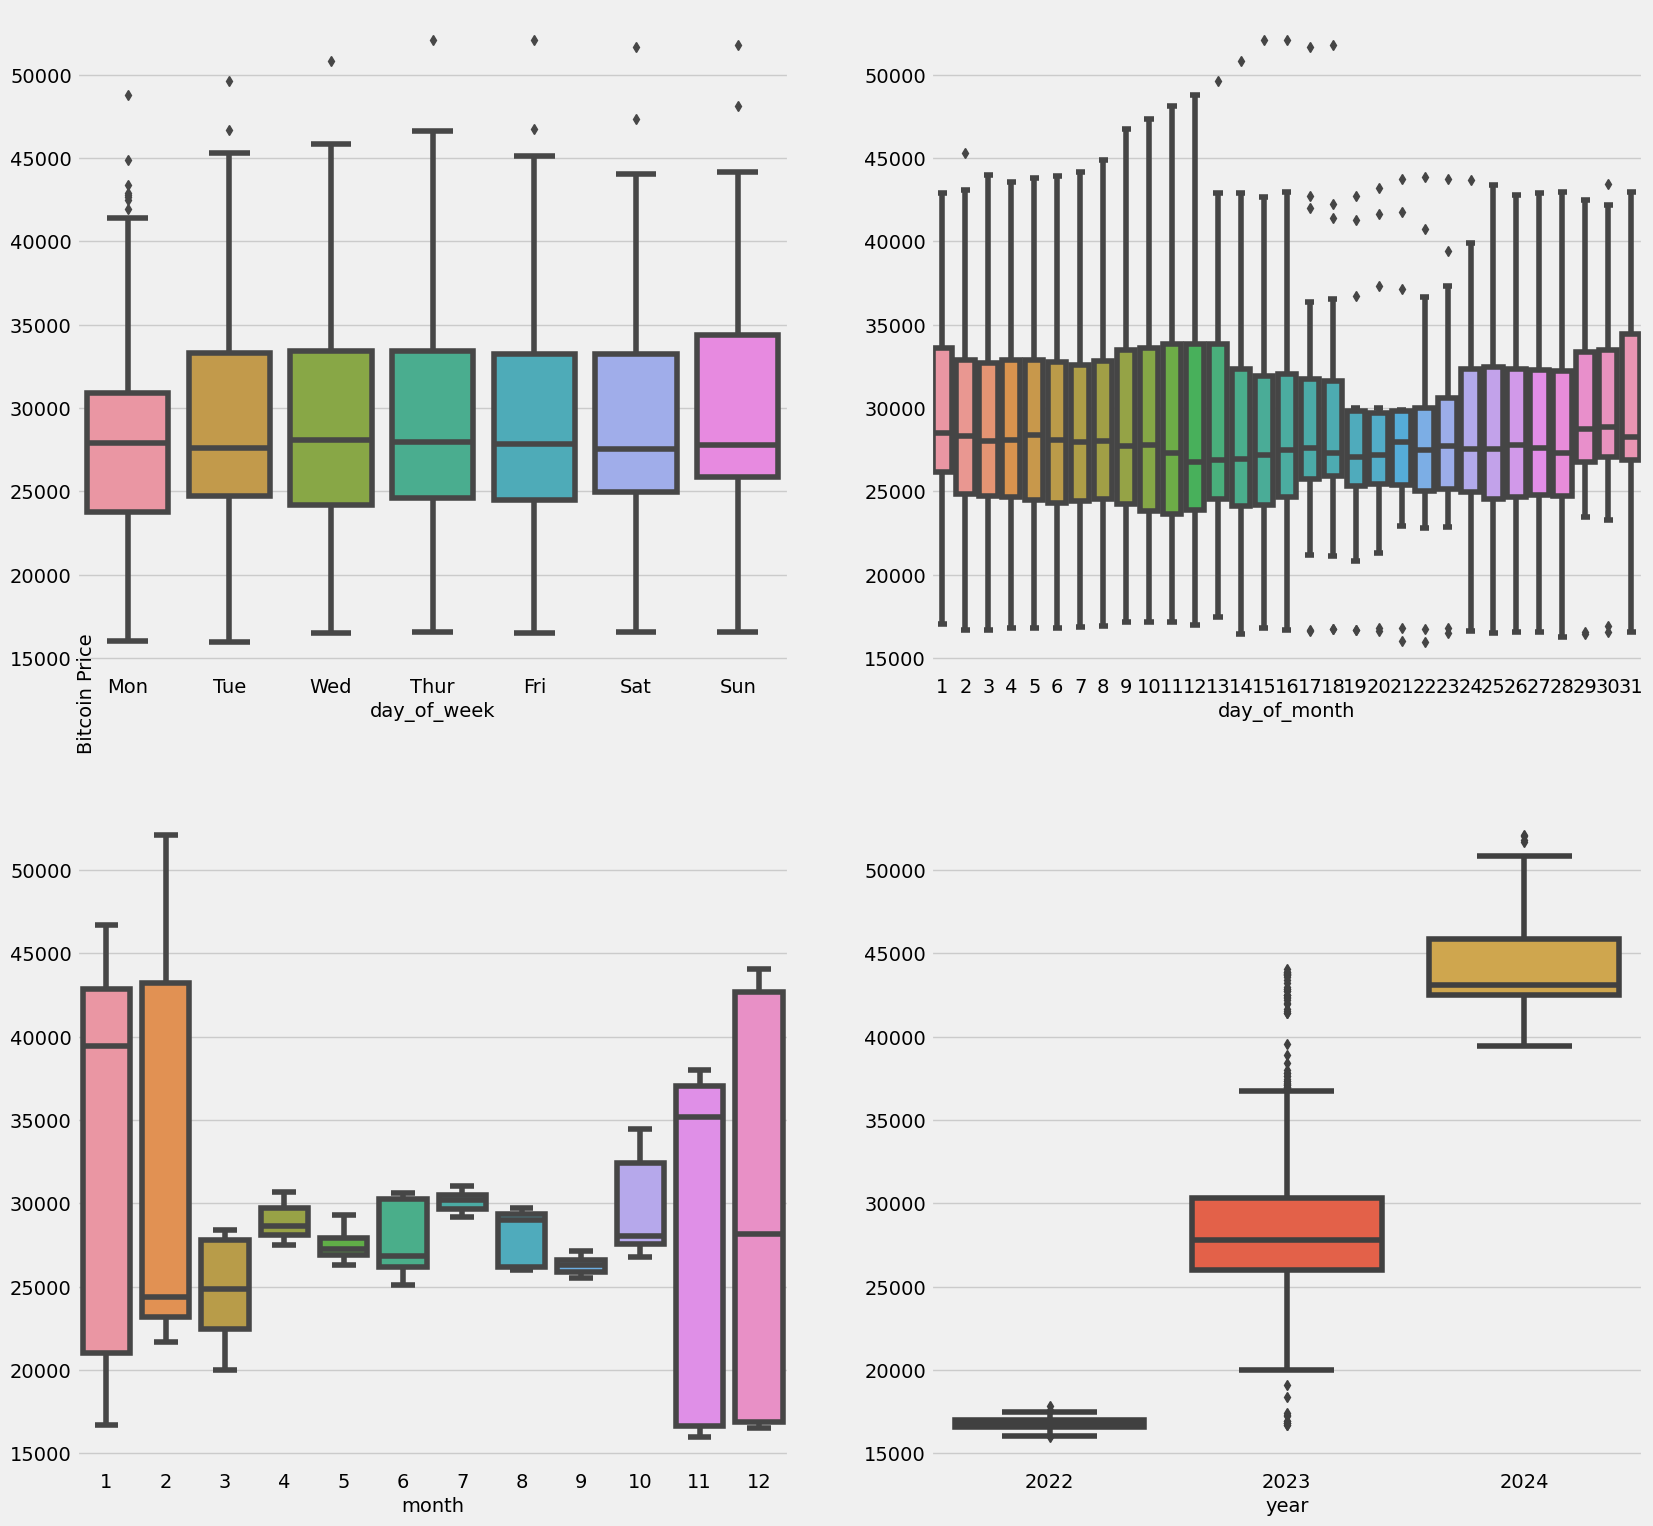

In [14]:
df = prepared_data.copy()
fig, axes = plt.subplots(2, 2, figsize=(18,18))

# Day of Week
dow_labels = ['Mon','Tue','Wed','Thur','Fri','Sat','Sun']
g = sns.boxplot(x=df.day_of_week, y=df.priceUsd, ax=axes[0][0])
g.set_xticklabels(dow_labels)
g.set_ylabel('')

# Day of Month
g = sns.boxplot(x=df.day_of_month,  y=df.priceUsd, ax=axes[0][1])
g.set_ylabel('')

# Month of Year
g = sns.boxplot(x=df.month,  y=df.priceUsd, ax=axes[1][0])
g.set_ylabel('')

# Year
g = sns.boxplot(x=df.year, y=df.priceUsd, ax=axes[1][1])
g.set_ylabel('')
fig.text(0.08,0.5, 'Bitcoin Price', va='center', rotation='vertical')

plt.show()

* ##### Insights: 
Bitcoin price was relatively stable during the week, experience slight turbulence during the month but saw high turbulence in a 12-month period. Additionally, Bitcoin prices is observed to have increased over the years i.e., from 2022 to 2024

##### Seasonal Plot: Year-Month

In [15]:
import plotly.express as px
import matplotlib
df_copy = df.copy()
year_group = df_copy.groupby(['year', 'month']).mean().reset_index()
year_group = year_group[['year', 'month', 'priceUsd']]
years = df_copy['year'].unique()
NUM_COLOURS = len(years)
cm = plt.get_cmap('gist_rainbow')

# Convert colormap tuple to list of hex colors
color_list = [matplotlib.colors.rgb2hex(cm(1. * i / NUM_COLOURS)) for i in range(NUM_COLOURS)]

fig = px.line(df_copy, x='month', y='priceUsd', color='year',
              line_group='year',
              color_discrete_sequence=color_list,
              labels={'priceUsd': 'Bitcoin Prices'},
              title='Monthly Average Bitcoin Prices Over Years')

fig.update_layout(xaxis_title='Month', yaxis_title='Bitcoin Prices')
fig.show()

##### Splitting data into train and test

In [16]:
sql_query = 'SELECT date, priceUsd FROM bitcoin_price_data order by date;'
daily_bitcoin_prices = extract_data_from_db('test_db',sql_query)
df = daily_bitcoin_prices.copy()
prepared_data = feature_engineering(df)
df_copy = prepared_data.copy()

In [17]:
def train_val_test_split(df: DataFrame):
    TARGET_VAL_CUTOFF_DATE = '2023-12-01'
    TARGET_TEST_CUTOFF_DATE = '2024-01-01'
    train = df_copy.loc[pd.to_datetime(df_copy.index) < TARGET_VAL_CUTOFF_DATE]

    val = df_copy.loc[(pd.to_datetime(df_copy.index) >= TARGET_VAL_CUTOFF_DATE) & 
                             (pd.to_datetime(df_copy.index) < TARGET_TEST_CUTOFF_DATE)]

    test = df_copy.loc[pd.to_datetime(df_copy.index) >= TARGET_TEST_CUTOFF_DATE]

    train_and_val = df_copy.loc[pd.to_datetime(df_copy.index) < '2024-01-01']

    features = ['year','month','week_of_year','day_of_year','day_of_month','day_of_week']
    target = 'priceUsd'
    dataframes = {}
    dataframes["X_train"] = train[features]
    dataframes["y_train"] = train[target]
    dataframes["X_val"] = val[features]
    dataframes["y_val"] = val[target]
    dataframes["X_test"] = test[features]
    dataframes["y_test"] = test[target]
    dataframes["X_train_val"] = train_and_val[features]
    dataframes["y_train_val"] = train_and_val[target]
    dataframes['test'] = test
    dataframes['train'] = train
    dataframes['val'] = val
    
    return dataframes

# print(f'Shape of X_Train dataset {X_train.shape}')
# print(f'Shape of X_Train dataset {y_train.shape}')
# print(f'Shape of X_val dataset {X_val.shape}')
# print(f'Shape of y_val dataset {y_val.shape}')
# print(f'Shape of X_test dataset {X_test.shape}')
# print(f'Shape of y_test dataset {y_test.shape}')
# print(f'Shape of X_train_and_val dataset {X_train_val.shape}')
# print(f'Shape of y_train_and_val dataset {y_train_val.shape}')

##### Training the model

In [18]:
from sklearn.model_selection import cross_val_score, KFold
import xgboost as xgb

def train_xgb_regressor_cv(X, y, use_gpu=False):
    """
    Train an XGBoost Regressor model using cross-validation.

    Args:
        X: Feature set.
        y: Target set.
        use_gpu (bool): Whether to use GPU for training. Default is False.

    Returns:
        xgb.XGBRegressor: Trained XGBoost Regressor model.
    """
    additional_params = {}
    if use_gpu:
        additional_params = {'tree_method': 'gpu_hist', 'gpu_id': 0}

    xgb_regressor = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                                     n_estimators=3000,
                                     objective='reg:squarederror',  # Updated objective
                                     max_depth=6,
                                     learning_rate=0.01,
                                     min_child_weight=1,
                                     subsample=0.8,
                                     colsample_bytree=0.8,
                                     gamma=0,
                                     reg_alpha=0,
                                     reg_lambda=1,
                                     **additional_params)

    # Specify the number of folds for cross-validation
    num_folds = 5  # You can adjust this number based on your preference

    # Use KFold for cross-validation
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    # Perform cross-validation
    for train_index, val_index in kf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        xgb_regressor.fit(X_train, y_train,
                          eval_set=[(X_train, y_train), (X_val, y_val)],
                          early_stopping_rounds=50,  # Updated early_stopping_rounds
                          eval_metric='rmse', verbose=100)

    return xgb_regressor

In [19]:
## Obtain X_train_val, y_train_val,X_test, y_test, test from dictionary
dct = train_val_test_split(df_copy)
X_train_val = dct['X_train_val']
y_train_val = dct['y_train_val']
X_test = dct['X_test']
y_test = dct['y_test']
test = dct['test']

In [20]:
trained_model_cv = train_xgb_regressor_cv(X_train_val,y_train_val, use_gpu=False)

[0]	validation_0-rmse:27961.64577	validation_1-rmse:28134.53214
[100]	validation_0-rmse:10719.89172	validation_1-rmse:11120.33047


C:\Users\5300\AppData\Local\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

C:\Users\5300\AppData\Local\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[200]	validation_0-rmse:4308.73143	validation_1-rmse:4627.09990
[300]	validation_0-rmse:1832.75836	validation_1-rmse:2131.01702
[400]	validation_0-rmse:873.28471	validation_1-rmse:1172.00603
[500]	validation_0-rmse:510.80331	validation_1-rmse:823.66503
[600]	validation_0-rmse:345.53432	validation_1-rmse:669.45320
[700]	validation_0-rmse:262.10976	validation_1-rmse:592.58483
[800]	validation_0-rmse:214.07845	validation_1-rmse:555.08314
[900]	validation_0-rmse:180.12408	validation_1-rmse:535.02755
[1000]	validation_0-rmse:156.51905	validation_1-rmse:523.22486
[1100]	validation_0-rmse:135.60424	validation_1-rmse:516.64090
[1200]	validation_0-rmse:117.92178	validation_1-rmse:512.72193
[1300]	validation_0-rmse:102.80013	validation_1-rmse:509.77651
[1400]	validation_0-rmse:89.94938	validation_1-rmse:507.07100
[1500]	validation_0-rmse:80.09743	validation_1-rmse:505.49515
[1600]	validation_0-rmse:71.11911	validation_1-rmse:504.05105
[1638]	validation_0-rmse:68.49757	validation_1-rmse:504.21228

##### Check for underfitting/overfitting of model

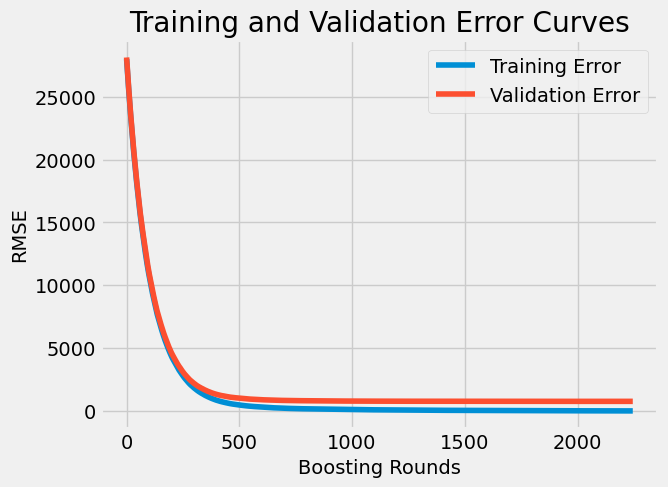

In [21]:
def plot_learning_curve(evals_result):
    train_error = evals_result['validation_0']['rmse']
    val_error = evals_result['validation_1']['rmse']

    plt.plot(train_error, label='Training Error')
    plt.plot(val_error, label='Validation Error')
    plt.xlabel('Boosting Rounds')
    plt.ylabel('RMSE')
    plt.title('Training and Validation Error Curves')
    plt.legend()
    plt.show()

# Get evaluation results
evals_results = trained_model_cv.evals_result()

# Plot eval results
plot_learning_curve(evals_results)

##### Evaluate weight of features in prediction

In [22]:
def plot_feature_importance(model):
    """
    Plot the feature importance of a trained XGBoost model.

    Args:
        model (xgb.XGBRegressor): Trained XGBoost Regressor model.

    Returns:
        None
    """
    feat_importances = pd.DataFrame(data=model.feature_importances_,
                      index=model.feature_names_in_,
                      columns=['importance']).sort_values('importance',ascending=True)
    
    # Create a horizontal bar chart
    fig = go.Figure(go.Bar(
        x=feat_importances['importance'],
        y=feat_importances.index,
        orientation='h',
        marker=dict(color='rgba(50, 171, 96, 0.6)'), 
    ))

    # Customize layout
    fig.update_layout(
        title='Feature Importance',
        xaxis=dict(title='Importance'),
        yaxis=dict(title='Feature'),)

    # Show the plot
    fig.show()


#     feat_importances.sort_values('importance').plot(kind='barh', title='Feature Importance')
#     plt.show()

plot_feature_importance(trained_model_cv)

##### Inference on Test

In [23]:
test['prediction'] = trained_model_cv.predict(X_test)

C:\Users\5300\AppData\Local\Temp\ipykernel_14568\513920866.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [24]:
prepared_data = df_copy.merge(test[['prediction']], how='left', left_index=True, right_index=True)

In [25]:
prepared_data

,year,month,week_of_year,day_of_year,day_of_month,day_of_week,priceUsd,prediction
date,,,,,,,,
2022-11-14,2022,11,46,318,14,0,16453.42,NaN
2022-11-15,2022,11,46,319,15,1,16828.17,NaN
2022-11-16,2022,11,46,320,16,2,16703.82,NaN
2022-11-17,2022,11,46,321,17,3,16620.22,NaN
2022-11-18,2022,11,46,322,18,4,16751.87,NaN
...,...,...,...,...,...,...,...,...
2024-02-14,2024,2,7,45,14,2,50836.53,23126.216797
2024-02-15,2024,2,7,46,15,3,52093.35,22903.972656
2024-02-16,2024,2,7,47,16,4,52056.76,24295.144531


In [26]:
import plotly.graph_objects as go
import pandas as pd

# Create a Figure
fig = go.Figure()

# Add the 'priceUsd' trace
fig.add_trace(go.Scatter(x=prepared_data.index, y=prepared_data['priceUsd'], mode='lines', name='Ground True Data'))

# Add the 'prediction' trace
fig.add_trace(go.Scatter(x=prepared_data.index, y=prepared_data['prediction'], mode='lines', name='Predictions'))

# Update layout
fig.update_layout(title="Actual Past Data and Prediction", xaxis_title="Date", yaxis_title="Price",
                  legend=dict(x=0, y=1, traceorder="normal"))

# Show the plot
fig.show()

In [27]:
prepared_data_week = prepared_data.loc[(pd.to_datetime(prepared_data.index) > '2024-01-01') &
                                      (pd.to_datetime(prepared_data.index) <= '2024-01-07')]
# Create a Figure
fig = go.Figure()

# Add the 'priceUsd' trace
fig.add_trace(go.Scatter(x=prepared_data_week.index, y=prepared_data_week['priceUsd'], mode='lines', name='Ground True Data'))

# Add the 'prediction' trace
fig.add_trace(go.Scatter(x=prepared_data_week.index, y=prepared_data_week['prediction'], mode='lines', name='Predictions'))

# Update layout
fig.update_layout(title="Actual Past Data and Prediction", xaxis_title="Date", yaxis_title="Price",
                  legend=dict(x=0, y=1, traceorder="normal"))

# Show the plot
fig.show()

##### Estimation of Root Mean Squared Error (RMSE)

In [28]:
score = np.sqrt(mean_squared_error(test['priceUsd'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 23486.20


* ###### Insights: 
The Root Mean Squared Score is very large, inferring that the model has poor performance. The Feature Importance plot reveals that year, month, day_of_year and week_of_year column had more effect on prediction while day_of_month and day_of_week had negligible effect. The latter will be dropped, other forms of feature engineering will be performed and the current model will be retrained. Additionally, other models would be explored. 

###### Create dataframe for future date, predict daily bitcoin price and obtain average monthly price for February

In [29]:
last_date = prepared_data.index.max()

In [37]:
# Generate dates for the next month (February)
next_month_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=42, freq='D')

# Create a new DataFrame for the next month with NaN values
df = pd.DataFrame(index=next_month_dates)
df['date'] = df.index
# df['date'] = pd.to_datetime(df['date'] + ' 00:00:00')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['week_of_year'] = df['date'].dt.isocalendar().week.astype('int64')  # Corrected line
df['day_of_year'] = df['date'].dt.dayofyear
df['day_of_week'] = df['date'].dt.dayofweek
df['day_of_month'] = df['date'].dt.day
df['priceUsd'] = 'NaN'
# df= df.set_index('date')
# df.index = pd.to_datetime(df.index)
df.dropna(inplace=True)
future_X_test = df[['year', 'month', 'week_of_year','day_of_year','day_of_month', 'day_of_week']]
future_X_test.head()

,year,month,week_of_year,day_of_year,day_of_month,day_of_week
2024-02-19,2024,2,8,50,19,0
2024-02-20,2024,2,8,51,20,1
2024-02-21,2024,2,8,52,21,2
2024-02-22,2024,2,8,53,22,3
2024-02-23,2024,2,8,54,23,4


In [38]:
future_X_test['prediction'] = trained_model_cv.predict(future_X_test)

C:\Users\5300\AppData\Local\Temp\ipykernel_14568\3575731623.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [39]:
february_bitcoin_price = future_X_test.query("month==2")['prediction'].mean()
print(f'Bitcoin price for February: {february_bitcoin_price:0.2f}')

Bitcoin price for February: 23983.03


## PART 2: Modeling Retention

**Scenario:** It is November 7th, 2023. You need to prepare data for a retention analysis for a mobile game, by first creating the underlying data model, and then calculating the resulting metric.

**Definitions:**

* A New User is Retained on Day-X, if the User is Still Active on Day X after Registration, e.g. Day-1 Retained means that the User is Active One Day after Registration.
* Day-X Retention = (New Users Still Active on Day X / New Users) × 100

**Note:** Day-X Retention can only be calculated for users who have had a chance to reach Day X, e.g. it's impossible to calculate Day-30 Retention today, for a new user who registered only yesterday.

**Goals:**
1. Write SQL statements to
  1. Create a fact table needed to calculate Retention (for any `day` X since register between 1 and 3) for any cohort of players (`register_date, platform, country`)
  2. Compare Day-1, Day-2, and Day-3 Retention between the iOS & Android platforms
2. Plot the resulting data
3. Discuss the results

Resources:
*   *t_new_users.csv*: data on newly registered users
* *t_active_users.csv*: data on user activity

##### Read in data

In [40]:
## ANSWER PART 2 HERE. Feel Free to use mutliple cells if needed.
t_new_users = pd.read_csv('t_new_users.csv')
t_active_users = pd.read_csv('t_active_users.csv')

In [41]:
t_new_users.head()

,user_id;source;register_date;register_country;register_platform
0,e42de09ccd48584336f8;Tester;2023-10-30;IT;android
1,e51c004c06bd35d92fce;Tester;2023-10-30;ID;ios
2,e23e004c06bd35d90639;Tester;2023-10-30;RS;ios
3,02ccb20e77e916840190;Tester;2023-10-30;PL;android
4,1deab20e77e916851927;Tester;2023-10-30;PL;ios


In [713]:
t_active_users.head()

,user_id;active_date;n_sessions;playtime_mins
0,e23e004c06bd35d90639;2023-11-01;5;85.95
1,0074004c06bd35db0fb8;2023-11-05;2;53.03
2,0074004c06bd35db0fb8;2023-10-30;3;61.67
3,df65cce002b88a65c2b1;2023-11-06;2;5.6
4,e0cc3cdcb19cfce76366;2023-10-31;7;410.32


* Note: The data has only one column and isn't in the correct format, necessitating some data cleaning

##### Prepare data

In [42]:
t_new_users['user_id'] = t_new_users['user_id;source;register_date;register_country;register_platform'].apply(lambda x: x.split(';')[0])
t_new_users['source'] = t_new_users['user_id;source;register_date;register_country;register_platform'].apply(lambda x: x.split(';')[1])
t_new_users['register_date'] = t_new_users['user_id;source;register_date;register_country;register_platform'].apply(lambda x: x.split(';')[2])
t_new_users['register_country'] = t_new_users['user_id;source;register_date;register_country;register_platform'].apply(lambda x: x.split(';')[3])
t_new_users['register_platform'] = t_new_users['user_id;source;register_date;register_country;register_platform'].apply(lambda x: x.split(';')[4])
t_new_users.drop(columns = ['user_id;source;register_date;register_country;register_platform'],inplace=True)
t_new_users.to_csv('cleaned_t_new_users.csv',index=False)

t_active_users['user_id'] = t_active_users['user_id;active_date;n_sessions;playtime_mins'].apply(lambda x: x.split(';')[0])
t_active_users['active_date'] = t_active_users['user_id;active_date;n_sessions;playtime_mins'].apply(lambda x: x.split(';')[1])
t_active_users['n_sessions'] = t_active_users['user_id;active_date;n_sessions;playtime_mins'].apply(lambda x: x.split(';')[2])
t_active_users['playtime_mins'] = t_active_users['user_id;active_date;n_sessions;playtime_mins'].apply(lambda x: x.split(';')[3])
t_active_users.drop(columns = ['user_id;active_date;n_sessions;playtime_mins'],inplace=True)
t_active_users.to_csv('cleaned_t_active_users.csv',index=False)

##### Read in cleaned data

In [43]:
cleaned_t_new_users = pd.read_csv('cleaned_t_new_users.csv')
cleaned_t_active_users = pd.read_csv('cleaned_t_active_users.csv')

In [44]:
cleaned_t_new_users.head()

,user_id,source,register_date,register_country,register_platform
0,e42de09ccd48584336f8,Tester,2023-10-30,IT,android
1,e51c004c06bd35d92fce,Tester,2023-10-30,ID,ios
2,e23e004c06bd35d90639,Tester,2023-10-30,RS,ios
3,02ccb20e77e916840190,Tester,2023-10-30,PL,android
4,1deab20e77e916851927,Tester,2023-10-30,PL,ios


In [45]:
cleaned_t_new_users.head()

,user_id,source,register_date,register_country,register_platform
0,e42de09ccd48584336f8,Tester,2023-10-30,IT,android
1,e51c004c06bd35d92fce,Tester,2023-10-30,ID,ios
2,e23e004c06bd35d90639,Tester,2023-10-30,RS,ios
3,02ccb20e77e916840190,Tester,2023-10-30,PL,android
4,1deab20e77e916851927,Tester,2023-10-30,PL,ios


In [46]:
print(f'shaped of cleaned active_users dataset: {cleaned_t_active_users.shape}')
print(f'shaped of cleaned new_users dataset: {cleaned_t_new_users.shape}')

shaped of cleaned active_users dataset: (1899, 4)
shaped of cleaned new_users dataset: (610, 5)


##### 1. Fact table query

Note: PostgreSQL database was used to generate the following SQL questions

In [48]:
'''
This SQL query joins the new_users and active_users 
table on the user_id column and utilizes case when statement to return 1 or 0 if the user was active for
first, second and third days after registration
'''
with combined as 
(select au.user_id, nu.source_data,nu.register_country,nu.register_platform,nu.register_date,
au.active_date, au.n_sessions, au.playtime_mins,
case when active_date::DATE - register_date::DATE=1 then 1 else 0 end as active_day_one,
case when active_date::DATE - register_date::DATE=2 then 1 else 0 end as active_day_two,
case when active_date::DATE - register_date::DATE=3 then 1 else 0 end as active_day_three
from public.active_users au
left join public.new_users nu on au.user_id=nu.user_id
where nu.register_platform is not null
order by nu.user_id, au.active_date)

select * from combined

##### 2. Retention comparison for iOS and android platforms

In [ ]:
'''
This SQL query utilizes a group by statement to estimate the Retention for each platform. The query was used to
'''
select register_platform,count(distinct user_id) unique_users,
round(sum(active_day_one)/CAST(COUNT(DISTINCT user_id) AS DECIMAL(10, 2))*100,2) Day_1_pct_retention,
round(sum(active_day_two)/CAST(COUNT(DISTINCT user_id) AS DECIMAL(10, 2))*100,2) Day_2_pct_retention,
round(sum(active_day_three)/CAST(COUNT(DISTINCT user_id) AS DECIMAL(10, 2))*100,2) Day_3_pct_retention
from combined
group by 1

In [49]:
retention_platform_summary = pd.read_csv('retention_comparison_for_platforms.csv')

##### 3. Plots of retention comparison between iOS and android platforms

In [50]:
'''
This Python codes melts the retention_platform_summary into another dataframe, making it easier to plot
'''
# Melt the dataframe for Plotly plotting
df_melted = pd.melt(
    retention_platform_summary,
    id_vars=["register_platform", "unique_users"],
    var_name="retention_day",
    value_name="pct_retention",
)

# Plotting with Plotly
fig = px.bar(
    df_melted,
    x="register_platform",
    y="pct_retention",
    color="retention_day",
    barmode="group",
    title="Retention Comparison between Platforms for Each Day",
    labels={"register_platform": "Platform", "pct_retention": "Percentage Retention"},
)

# Show the plot
fig.show()

###### Discussion of results

* The plotted data depicting "Retention Comparison between Platforms for Each Day" suggests a noteworthy trend: the iOS platform exhibits higher retention rates compared to the Android platform on day 1, day 2, and day 3 following user registration. This discrepancy may be attributed to various factors, including disparities in speed and performance during mobile gaming experiences.

* One plausible explanation lies in the distinctive approach of Apple, where both hardware and software for iOS devices are meticulously designed and integrated. This tight integration and optimization contribute to a seamless and efficient user experience. In contrast, the Android ecosystem involves diverse manufacturers producing hardware components, leading to potential variations in performance across different devices.

## PART 3: Investigating Data Issue

**Scenario:**

You're analyzing gameplay data for Trial Xtreme at Gameplay Galaxy. The dataset has session information, but there's a known issue with session length calculation due to sessions not closing correctly after 5 minutes of inactivity, and therefore session IDs not resetting correctly.  This led to inaccurate daily playtime calculations per user:

***Summary Statistics: Playtime Minutes per User per Day***
```
count	1192.000000
mean	81.960668
std	147.130393
min	0.000000
25%	11.212500
50%	31.016667
75%	83.016667
max	1303.266667
```


**Goals:**

1. Start by examining the above table, which shows summary statistics for Playtime Minutes per User per Day. Can you identify any issue(s) in the data that might lead to incorrect average playtime calculations? The code that generates the results can be found below. Feel free to explore the raw data in event_data.csv, if needed.
2. Given the identified issue(s), how would you approach correcting the calculation to ensure accurate playtime metrics? Please provide Python or SQL code, or simply explain the steps or modifications needed to address the issue.
3. What improvements do you expect to achieve in playtime calculations after implementing the necessary changes in the SQL query?


Python Code to generate above Summary Statistics table (for added reference only):

In [51]:
import pandas as pd

# Reading the CSV file
file_path = 'event_data.csv'  # Replace with path to the CSV file, if needed
event_data = pd.read_csv(file_path)

# Converting 'timestamp' from string to datetime
event_data['timestamp'] = pd.to_datetime(event_data['timestamp'])

# Grouping by date, session_id, and user_id, and calculating max and min timestamps
grouped_data = event_data.groupby([event_data['timestamp'].dt.date, 'session_id', 'user_id']).agg(
    max_timestamp=('timestamp', 'max'),
    min_timestamp=('timestamp', 'min')
).reset_index()

# Calculating playtime in minutes
grouped_data['playtime_minutes'] = (grouped_data['max_timestamp'] - grouped_data['min_timestamp']).dt.total_seconds() / 60

# Summing playtime grouped by user_id and day
daily_user_playtime = grouped_data.groupby(['user_id', grouped_data['timestamp']]).agg(
    daily_playtime_minutes_per_user =('playtime_minutes', 'sum')
).reset_index()

# Generating summary statistics for daily playtime
summary_statistics = daily_user_playtime['daily_playtime_minutes_per_user'].describe()

# Displaying the summary statistics
pd.DataFrame(summary_statistics)

,daily_playtime_minutes_per_user
count,1192.000000
mean,81.960668
std,147.130393
min,0.000000
25%,11.212500
50%,31.016667
75%,83.016667
max,1303.266667


##### 1. Solution to incorrect metrics calculation

* After a thorough analysis of the data, I have observed that the current method of estimating session length relies on the minimum and maximum timestamps for each session_id. Notably, the minimum timestamp, associated with the "user_session_start" event, appropriately marks the commencement of a session. However, the maximum timestamp, linked to the conclusion of a session, lacks a corresponding "user_end_session" record in the event column.

* This absence of an "user_end_session" event for the maximum timestamp introduces inaccuracies in determining when a user's session concludes or when there is a 5-minute period of inactivity.

* To enhance the precision of our analytics, I recommend implementing a product feature that automatically inserts a "user_end_session" record into the event column, along with the corresponding timestamp, whenever a user session concludes or when there is a 5-minute interval of inactivity. By adopting this approach, we can ensure an accurate estimation of the session time by considering the duration between the "user_session_start" and "user_end_session" events.

##### 2. Approach to ensure accurate metrics calculations

In [ ]:
## SQL
WITH filtered_event_data AS (
    SELECT
        *,
        CASE WHEN event = 'user_start_session' THEN timestamp ELSE NULL END AS session_start_timestamp,
        CASE WHEN event = 'user_end_session' THEN timestamp ELSE NULL END AS session_end_timestamp
    FROM
        event_data
    WHERE
        event IN ('user_start_session', 'user_end_session')
),

user_and_session_playtime AS (
    SELECT
        user_id,
        session_id,
        (CAST(session_start_timestamp AS TIMESTAMP) - CAST(session_end_timestamp AS TIMESTAMP)) / 60 AS session_playtime
    FROM
        filtered_event_data
),

user_daily_playtime AS (
    SELECT
        user_id,
        SUM(session_playtime) AS user_daily_playtime
    FROM
        user_and_session_playtime
    GROUP BY
        user_id
)

SELECT
    AVG(user_daily_playtime) AS avg_playtime_per_user,
    MIN(user_daily_playtime) AS min_playtime,
    MAX(user_daily_playtime) AS max_playtime,
    COUNT(user_id) AS daily_user_count
FROM
    user_daily_playtime;


##### 3. Expected changes

* Following the implementation of the updated playtime calculation methodology, we anticipate precise user playtime metrics. This enhancement enables us to accurately determine the playtime for each user per day, as we now have precise timestamps indicating the initiation and conclusion of user sessions.